# Fairness Sandox Prototype

This rudimentary version of the framework will contain one dataset, one model, one bias mitigation algorithm, and a limited amount of validation metrics. Emphasis will be on modularity and abstraction so as to encourage more features in the future.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [ ]:
%pip install aif360
%pip install fairlearn
%pip install imbalanced-learn
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install scikit-learn

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
import aif360

import copy

# Data + EDA

### Dataset Class

In [2]:
class Dataset:
    def __init__(self, short_name = '', path = '', cat_cols = [], num_cols = []):
        self.short_name = short_name
        self.path = path
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.df = pd.read_csv(path, sep = ';')

### Popular Datasets

In [3]:
# each dataset is a dictionary where keys = short name, values = Dataset object

datasets = dict()

def add_dataset(dataset):
    if not isinstance(dataset, Dataset):
        print("Error! Please enter a valid Dataset object")
    else:
        if dataset.short_name not in datasets.keys():
            datasets[dataset.short_name] = dataset

In [4]:
# example - adding a dataset
path_adult_income = 'Datasets/adult.csv'
cat_cols = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race',
            'gender', 'native-country','income']
num_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_income = Dataset('adult_income', path_adult_income, cat_cols, num_cols)

add_dataset(adult_income)

# TODO - add more datasets

In [5]:
cat = ['school', 'sex', 'address','famsize','Pstatus','Mjob','Fjob','reason',
       'guardian','schoolsup','famsup','paid', 'activities','nursery','higher', 'internet','romantic']
num = ['age', 'Medu', 'Fedu','traveltime','studytime','failures', 'famrel',
       'freetime','goout','Dalc','Walc','health','absences','G1', 'G2', 'G3']

add_dataset(Dataset("student_mat", path='Datasets/student-mat.csv', cat_cols=cat, num_cols=num))
add_dataset(Dataset("student_por", path='Datasets/student-por.csv', cat_cols=cat, num_cols=num))

In [6]:
# (potential) TODO: add functionality for missing data + 
#       encoding categorical features

### EDA

Feel free to use any/all of the following EDA functions and/or add your own!

In [7]:
# take a peek at the first few data points
df_por = datasets['student_por'].df
df_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


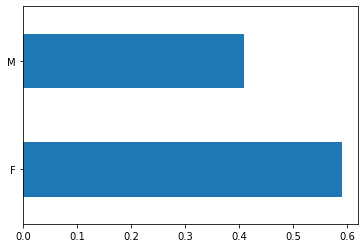

In [8]:
def plot_counts(df, attr):
    if attr in df.columns:
        df[attr].value_counts(normalize=True).plot.barh()
    else:
        print("Error! Please enter a valid feature.")

# example
plot_counts(df_por, 'sex')

F
M


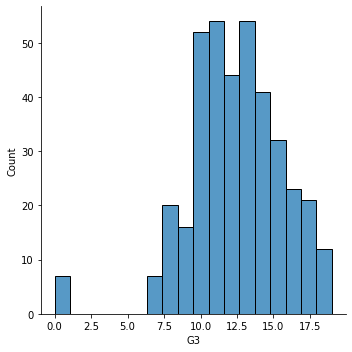

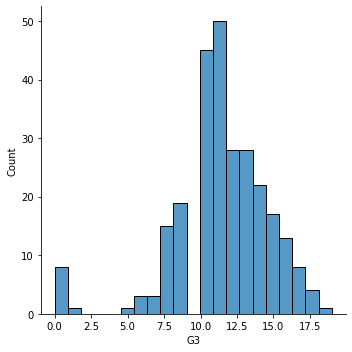

In [9]:
def group_by_plot(df, attr1, attr2):
    for val in list(df[attr1].unique()):
        print(val)
        temp = df[df[attr1] == val]
        sns.displot(temp[attr2])

# example
group_by_plot(df_por, 'sex', 'G3')

In [47]:
# add support for sns.pairplot, plt.scatter, sns.heatmap

# Preparation

### Problem Formulation

In [10]:
def threshold(df, g_1=0.3, g_2=0.3, g_3=0.4, threshold=11):
    """
    Added "pass/fail" to make problem binary classification
    """
    assert g_1 + g_2 + g_3 == 1, "The sum of the percentages should be 1"
    assert 0 < threshold < 20, "Threshold needs to be between 0 and 20"
    df['pass'] = df.apply(lambda row: 1
                                 if g_1*row['G1'] + g_2*row['G2'] + g_3*row['G3'] >= threshold
                                 else 0, axis=1)
#generate_pnp(datasetMath)
threshold(df_por, threshold=14)
# df_por['pass'].value_counts()

We will now ask you to identify potential sensitive/protected attributes. Run the chunk below to see the different features in the dataset.

In [49]:
# for reference
print(datasets['student_por'].cat_cols)
print(datasets['student_por'].num_cols)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


In [11]:
sens_attrs = [df_por['sex'], df_por['address']]

### Data Preprocessing

In [12]:
# format data
X = df_por.iloc[:, :-2].values
y = df_por.iloc[:, -1].values

In [13]:
# OHE categorical features (prompt for user's choice here?)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# get indices of categorical columns
def get_cat_cols(dataset):
    df = dataset.df
    res = []
    for col in dataset.cat_cols:
        res.append(df.columns.get_loc(col))
    return res

cat_cols = get_cat_cols(datasets['student_por'])
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [330]:
X_test = df_por.iloc[:, :-2]
X_dum = pd.get_dummies(X_test)
X_dum.columns
type(X)

numpy.ndarray

In [14]:
X_true = X
y_true = df_por['pass']

#X_bias = copy.deepcopy(X_true)
#y_bias = copy.deepcopy(y_true)

# Bias Injection

### Class Distribution Visualization

In [15]:
#df_por.shape
df_por['pass'].value_counts()

0    512
1    137
Name: pass, dtype: int64

<AxesSubplot:>

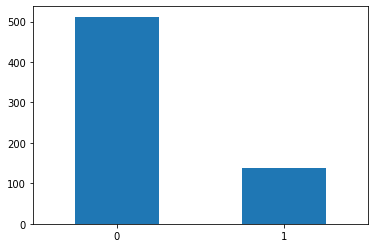

In [16]:
count = pd.value_counts(df_por['pass'], sort = True)
count.plot(kind = 'bar', rot = 0)

In [17]:
print('Ground Truth Label Distribution \n{}'.format(Counter(y_true)))

Ground Truth Label Distribution 
Counter({0: 512, 1: 137})


### Bias Selection

In [18]:
import imblearn

from imblearn.over_sampling import *
from imblearn.under_sampling import *

### Bias Injection

In [19]:
# Over-Sampling with SMOTE

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_true, y_true)

In [54]:
# Under-Sampling with Repeated Edited Nearest Neighbours

renn = RepeatedEditedNearestNeighbours(sampling_strategy="majority", max_iter=3, n_neighbors=3)
X_renn, y_renn = renn.fit_resample(X_true, y_true)

print(X_true.shape)
#print(df_por.shape)
#print(X_true)
X_renn.shape

(649, 58)


(591, 58)

In [379]:
np.isin(X_renn[4], X_true)

#np.where(X_true == X_renn[4])
np.where(np.all(X_true == X_renn[4], axis = 1))[0][0]

5

In [55]:
arr_renn = []
for i in range(X_renn.shape[0]):
    val = np.where(np.all(X_true == X_renn[i], axis = 1))[0][0]
    arr_renn.append(val)

#len(arr_renn)

sens_attrs_bias = []
for index in arr_renn:
    val = df_por['address'][index]
    sens_attrs_bias.append(val)
    
#len(sens_attrs_bias)

df_addr = pd.DataFrame(sens_attrs_bias, columns=["address"])


### Post-Injection Visualization

In [314]:
# TODO - add support for visualizing counts of minority and majority classes 
#.  (before and after bias injection)

print("Over-Sampling with SMOTE\n")
print('Ground Truth Label Distribution \n{}'.format(Counter(y_true)))
print('Biased Data Label Distribution \n{}'.format(Counter(y_smote)))

Over-Sampling with SMOTE

Ground Truth Label Distribution 
Counter({0: 512, 1: 137})
Biased Data Label Distribution 
Counter({0: 512, 1: 512})


In [44]:
x_vals = list(Counter(y_true).keys())
y_vals_truth = list(Counter(y_true).values())
y_vals_smote = list(Counter(y_smote).values())

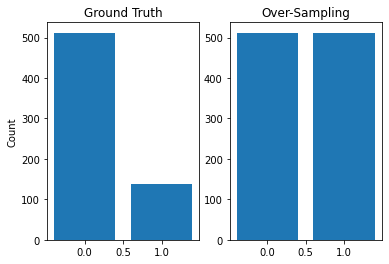

In [316]:
plt.subplot(1,2,1)
plt.bar(x_vals, y_vals_truth)
plt.title("Ground Truth")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.bar(x_vals, y_vals_smote)
plt.title("Over-Sampling")

plt.show()

In [56]:
print("Under-Sampling with Repeated Edited Nearest Neighbors\n")
print('Ground Truth Label Distribution \n{}'.format(Counter(y_true)))
print('Biased Data Label Distribution \n{}'.format(Counter(y_renn)))

Under-Sampling with Repeated Edited Nearest Neighbors

Ground Truth Label Distribution 
Counter({0: 512, 1: 137})
Biased Data Label Distribution 
Counter({0: 454, 1: 137})


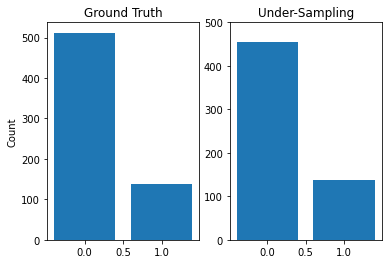

In [57]:
y_vals_renn = list(Counter(y_renn).values())

plt.subplot(1,2,1)
plt.bar(x_vals, y_vals_truth)
plt.title("Ground Truth")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.bar(x_vals, y_vals_renn)
plt.title("Under-Sampling")
plt.ylim([0,500])

plt.show()

# Model

### Model Selection + Training (TODO: modularize)

In [59]:
# modularize and add data struct of different ml techniques

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(min_samples_leaf = 10, max_depth = 4)

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

classifier_bias = classifier.fit(X_renn, y_renn)
y_pred_bias = classifier_bias.predict(X_renn)
y_pred_bias_on_true = classifier_bias.predict(X_true)

### Model Performance (TODO: modularize)

In [60]:
accuracy_score(y_pred_truth, y_true)

0.9845916795069337

In [61]:
accuracy_score(y_pred_bias, y_renn)

0.9966159052453468

In [62]:
accuracy_score(y_pred_bias_on_true, y_true)

0.9738058551617874

Thus, we can see that RENN (under-sampling method) increases model performance on the modified data BUT decreases model performance on the ground truth.

In [65]:
gm_true = MetricFrame(accuracy_score, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_true.overall)
print("Group Accuracy : ", gm_true.by_group)

Overall Accuracy:  0.9845916795069337
Group Accuracy :  address
R    0.979695
U    0.986726
Name: accuracy_score, dtype: object


In [66]:
gm_bias = MetricFrame(accuracy_score, y_renn, y_pred_bias, sensitive_features = df_addr)
print("Overall Accuracy: ", gm_bias.overall)
print("Group Accuracy : ", gm_bias.by_group)

Overall Accuracy:  0.9966159052453468
Group Accuracy :  address
R           1
U    0.995086
Name: accuracy_score, dtype: object


In [67]:
gm_bias_on_true = MetricFrame(accuracy_score, y_true,
                           y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_bias_on_true.overall)
print("Group Accuracy : ", gm_bias_on_true.by_group)

Overall Accuracy:  0.9738058551617874
Group Accuracy :  address
R    0.964467
U    0.977876
Name: accuracy_score, dtype: object


In [68]:
sr_true = MetricFrame(selection_rate, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_true.overall)
print("Group Selection Rate : ", sr_true.by_group)

Overall Selection Rate:  0.2110939907550077
Group Selection Rate :  address
R    0.177665
U    0.225664
Name: selection_rate, dtype: object


Thus, we can see that there is a **5% discrepancy** in the selection rate for Rural vs Urban students (with Urban students being preferred)

In [69]:
sr_bias = MetricFrame(selection_rate, y_renn, y_pred_bias, sensitive_features = df_addr)
print("Overall Selection Rate: ", sr_bias.overall)
print("Group Selection Rate : ", sr_bias.by_group)

Overall Selection Rate:  0.23181049069373943
Group Selection Rate :  address
R    0.168478
U    0.260442
Name: selection_rate, dtype: object


Thus, we can see that there is now a **10% discrepancy due to RENN** in the selection rate for Rural vs Urban students (with Urban students being preferred) on biased data

In [70]:
sr_bias_on_true = MetricFrame(selection_rate, y_true,
                              y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_bias_on_true.overall)
print("Group Selection Rate : ", sr_bias_on_true.by_group)

Overall Selection Rate:  0.23420647149460708
Group Selection Rate :  address
R    0.192893
U    0.252212
Name: selection_rate, dtype: object


In [73]:
print("EOD:", equalized_odds_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPD:", demographic_parity_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

print("EOR:", equalized_odds_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPR:", demographic_parity_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

EOD: 0.047169811320754707
DPD: 0.04799874219486994
EOR: 0.11994219653179189
DPR: 0.7872996914501842


### Fairness Visualization (Keep this?)

In [ ]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features = df_por['sex'],
                   sensitive_feature_names = ['sex'],
                   y_true = y_true,
                   y_pred = {"initial model" : y_pred})

In [ ]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features = df_por['address'],
                   sensitive_feature_names = ['address'],
                   y_true = y_true,
                   y_pred = {"initial model" : y_pred})

# Fairness Intervention

In [98]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
np.random.seed(0)

In [95]:
constraint = DemographicParity()
mitigator_true = ExponentiatedGradient(classifier_true, constraint)
mitigator_true.fit(X_true, y_true, sensitive_features = sens_attrs[1])
y_pred_mitigated_true = mitigator_true.predict(X_true)

In [97]:
constraint = DemographicParity()
mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
mitigator_bias.fit(X_renn, y_renn, sensitive_features = df_addr)
y_pred_mitigated_bias = mitigator_bias.predict(X_renn)
y_pred_mitigated_bias_on_true = mitigator_bias.predict(X_true)

# Evaluation

In [86]:
sr_mitigated = MetricFrame(selection_rate, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated.overall)
print("Group Selection Rate : ", sr_mitigated.by_group)

Overall Selection Rate:  0.22650231124807396
Group Selection Rate :  address
R    0.228426
U    0.225664
Name: selection_rate, dtype: object


In [101]:
gm_mitigated = MetricFrame(accuracy_score, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated.overall)
print("Group Accuracy : ", gm_mitigated.by_group)

Overall Accuracy:  0.9784283513097073
Group Accuracy :  address
R    0.959391
U    0.986726
Name: accuracy_score, dtype: object


In [103]:
gm_mitigated_bias = MetricFrame(accuracy_score, y_renn, y_pred_mitigated_bias, sensitive_features = df_addr)
print("Overall Accuracy: ", gm_mitigated_bias.overall)
print("Group Accuracy : ", gm_mitigated_bias.by_group)

Overall Accuracy:  0.9780033840947546
Group Accuracy :  address
R    0.940217
U    0.995086
Name: accuracy_score, dtype: object


In [100]:
gm_mitigated_bias_on_true = MetricFrame(accuracy_score, y_true, y_pred_mitigated_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated_bias_on_true.overall)
print("Group Accuracy : ", gm_mitigated_bias_on_true.by_group)

Overall Accuracy:  0.9476117103235747
Group Accuracy :  address
R    0.878173
U    0.977876
Name: accuracy_score, dtype: object


In [104]:
accuracy_score(y_true, y_pred_mitigated_bias_on_true)

0.9476117103235747

In [105]:
accuracy_score(y_true, y_pred_truth)

0.9845916795069337

In [106]:
# TODO: create data structure of different ml performance metrics
#       get user input and modularize output shown

print("Overall Accuracy: ", gm_true.overall)
print("Group Accuracy : ", gm_true.by_group)
print('\n')
print("Overall Accuracy: ", gm_mitigated.overall)
print("Group Accuracy : ", gm_mitigated.by_group)
print('\n')
print("Overall Accuracy: ", gm_mitigated_bias_on_true.overall)
print("Group Accuracy : ", gm_mitigated_bias_on_true.by_group)

print('\n')

print("Overall Selection Rate: ", sr_true.overall)
print("Group Selection Rate : ", sr_true.by_group)
print('\n')
print("Overall Selection Rate: ", sr_mitigated.overall)
print("Group Selection Rate : ", sr_mitigated.by_group)

Overall Accuracy:  0.9845916795069337
Group Accuracy :  address
R    0.979695
U    0.986726
Name: accuracy_score, dtype: object


Overall Accuracy:  0.9784283513097073
Group Accuracy :  address
R    0.959391
U    0.986726
Name: accuracy_score, dtype: object


Overall Accuracy:  0.9476117103235747
Group Accuracy :  address
R    0.878173
U    0.977876
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.2110939907550077
Group Selection Rate :  address
R    0.177665
U    0.225664
Name: selection_rate, dtype: object


Overall Selection Rate:  0.22650231124807396
Group Selection Rate :  address
R    0.228426
U    0.225664
Name: selection_rate, dtype: object


Hence, we observe a decrease in overall and subgroup accuracy, but an **increase in disadvantaged subgroup selection rate**.

In [ ]:
FairlearnDashboard(sensitive_features = sens_attrs[1],
                   sensitive_feature_names = ['address'],
                   y_true = y_true,
                   y_pred = {"initial model" : y_pred, "mitigated model": y_pred_mitigated_true})